In [50]:
import pandas as  pd
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

## 1. Необходимо рассчитать текущий LTV юзера, используя когортный анализ

In [2]:
df = pd.read_excel('test case data analyst.xlsx')

In [3]:
df['purchase_date'].max() - df['purchase_date'].min()

Timedelta('50 days 00:00:00')

In [4]:
df['purchase_date'].min()

Timestamp('2020-01-01 00:00:00')

In [5]:
df.loc[df['is_trial_period'] == True].loc[df.loc[df['is_trial_period'] == True].duplicated()]

,product_id,quantity,is_trial_period,purchase_date,user_id
4557,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-04,9253232
5294,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-29,9061878
6224,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-10,9443919
8651,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-12,8577778
9344,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-10,1639577
...,...,...,...,...,...
108981,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-27,9031123
111306,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-13,9527949
112859,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-03,8279172
113287,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-17,8754110


Удалю дубликаты

In [6]:
df = df.drop_duplicates()

Я на всякий случай решил подстраховаться, вдруг есть пользователи которые решили платить сразу

In [7]:
df =  df.merge(df.groupby('user_id')['purchase_date'].min().reset_index().rename({'purchase_date':'first_ts'}, axis=1))

In [8]:
df['revenue'] = 0

In [9]:
df.loc[df['is_trial_period'] == False, 'revenue'] = 4.99

Для удобства, я решил использовать номера дней а  не даты

In [10]:
df['day_num'] = (df['purchase_date'] - df['purchase_date'].min()).dt.days 


In [11]:
df['first_ts_num'] = (df['first_ts'] - df['first_ts'].min()).dt.days

In [100]:

ltv_reg = pd.DataFrame()
for x in range(8):
    
    cogort = df.loc[(df['first_ts_num'] == x) & (df['day_num'] <= 42 + x)]
    cohort_size = cogort['user_id'].nunique()
    ltv =  (cogort.groupby('day_num')['revenue'].sum() / cohort_size ).cumsum()
    ltv_reg = ltv_reg.append(    

                { 'cohort_size' :cohort_size, 
                   7 : ltv[7 + x], 
                14 : ltv[14 + x],
                21 : ltv[21 + x],
                28 : ltv[28 + x],
                35 : ltv[35 + x],
                42 : ltv[42 + x]
                }, ignore_index=True
            )
ltv_reg

,cohort_size,7,14,21,28,35,42
0,370.0,4.315676,8.105378,11.490486,14.457514,17.384081,19.973486
1,546.0,4.268004,8.024212,11.204652,14.074359,16.660751,19.009524
2,575.0,4.443270,8.062104,11.247026,14.180278,16.809791,19.152922
3,633.0,4.304171,7.764850,10.791959,13.621991,16.239179,18.572575
4,661.0,4.295477,7.866233,11.089728,13.996157,16.736505,19.174887
5,542.0,4.281089,7.678339,10.762565,13.524557,16.074797,18.348838
6,474.0,4.200443,7.663966,10.769557,13.569852,16.096435,18.307194
7,436.0,4.257523,7.828349,10.918486,13.848394,16.572294,19.078739


Прирост лтв со временем уменьшается не очень сильно, это хорошие новости

Text(0.5, 1.0, 'LTV')

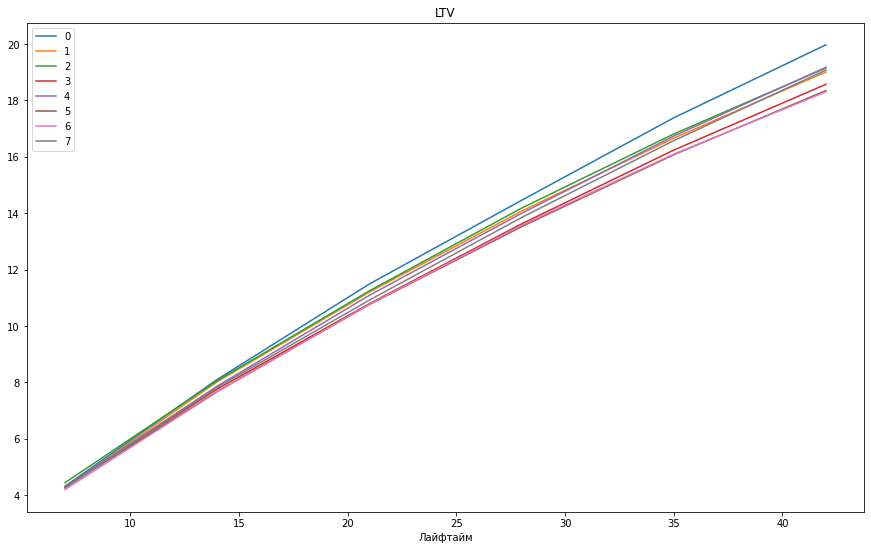

In [101]:
ltv_reg[ltv_reg.columns[1:]].T.plot(figsize = (15, 9))

plt.xlabel('Лайфтайм')
plt.title('LTV')

**Вывод:** у пользователей довольно большой цикл жизни, прирост снижается довольно медленно

## 2. Спрогнозировать, каким будет LTV на полгода.

Для этого я решил использовать линейную регрессию, думаю её будет вполне достаточно для такой задачи

In [33]:
weighted_average =  ltv_reg[ltv_reg.columns[1:]].mean().reset_index().rename(columns = {'index': 'day', 0:'revenue'})

Вначале посчитаю среднее лтв среди наших когорт 

In [37]:
weighted_average

,day,revenue
0,7,1.761101
1,14,3.228304
2,21,4.523930
3,28,5.702444
4,35,6.794150
5,42,7.770095


In [34]:
model = LinearRegression().fit(np.array(weighted_average['day']).reshape(-1, 1), weighted_average['revenue'])

In [35]:
model.score(np.array(weighted_average['day']).reshape(-1, 1), weighted_average['revenue'])


0.9949090469389663

предсказания не очень но, хоть так

In [36]:
model.predict(np.array(weighted_average['day']).reshape(-1, 1))

array([1.96897864, 3.16672216, 4.36446569, 5.56220921, 6.75995273,
       7.95769626])

In [41]:
model.predict(np.arange(7, 182, 7).reshape((-1, 1)))

array([ 1.96897864,  3.16672216,  4.36446569,  5.56220921,  6.75995273,
        7.95769626,  9.15543978, 10.35318331, 11.55092683, 12.74867036,
       13.94641388, 15.14415741, 16.34190093, 17.53964445, 18.73738798,
       19.9351315 , 21.13287503, 22.33061855, 23.52836208, 24.7261056 ,
       25.92384913, 27.12159265, 28.31933617, 29.5170797 , 30.71482322])

In [44]:
ltv_1cogort = pd.DataFrame()


cogort = df.loc[(df['first_ts_num'] == 0) & (df['day_num'] <= 50 )]
cohort_size = cogort['user_id'].nunique()
ltv =  (cogort.groupby('day_num')['revenue'].sum() / cohort_size ).cumsum()
ltv_1cogort = ltv_1cogort.append(    

            {  
                7 : ltv[7 ], 
            14 : ltv[14],
            21 : ltv[21],
            28 : ltv[28],
            35 : ltv[35],
            42 : ltv[42],
            50: ltv[50]
            }, ignore_index=True
        )
ltv_1cogort

,7,14,21,28,35,42,50
0,1.762472,3.310143,4.692583,5.904283,7.099459,8.156943,9.18138


In [48]:
ltv_1cogort = ltv_1cogort.T.reset_index().rename(columns = {'index': 'day', 0:'revenue'})

## 3. Построить график, который будет отображать кривую фактического LTV на фоне кривой прогнозируемого LTV.

Видно что предсказание довольно близко к реальному значению

No handles with labels found to put in legend.


Text(0.5, 1.0, 'LTV')

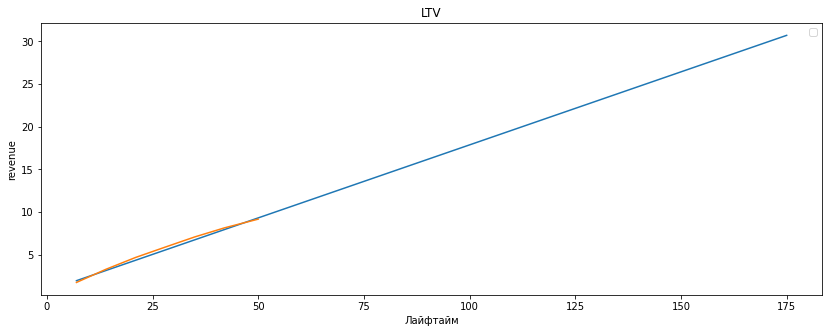

In [97]:
plt.figure(figsize=(14,5))

sns.lineplot(x = np.arange(7, 182, 7), y =  model.predict(np.arange(7, 182, 7).reshape((-1, 1))))
sns.lineplot(x = ltv_1cogort['day'], y =  ltv_1cogort['revenue'])
plt.legend()
plt.xlabel('Лайфтайм')
plt.title('LTV')

**Вывод:** прогнозируемые значения получились довольно близкими к первой когорте и очень оптимистичными.


## 4. Рассчитать ROMI на 4 недели и на полгода, если стоимость привлечения платящего пользователя 6 USD (ROMI нужно брать операционный, а не бухгалтерский, цель: узнать как окупятся наши инвестиции).

Так как нам нужны только платящие пользователи, то нужно исключить неплатящих

In [62]:
df = df.loc[df['is_trial_period'] == False]

In [89]:
cac = 6

In [90]:
romi = pd.DataFrame()
for x in range(22):
    
    cogort = df.loc[(df['first_ts_num'] == x) & (df['day_num'] <= 28 + x)]
    cohort_size = cogort['user_id'].nunique()
    ltv =  (cogort.groupby('day_num')['revenue'].sum() / cohort_size ).cumsum()
    romi = romi.append(    

                { 'cohort_size' :cohort_size, 
                   7 : ltv[7 + x] / cac, 
                14 : ltv[14 + x]/ cac,
                21 : ltv[21 + x]/ cac,
                28 : ltv[28 + x] / cac

                }, ignore_index=True
            )
romi

,cohort_size,7,14,21,28
0,357.0,0.745472,1.400089,1.984818,2.497330
1,529.0,0.734193,1.380347,1.927454,2.421109
2,564.0,0.754988,1.369891,1.911064,2.409474
3,609.0,0.745632,1.345142,1.869543,2.359803
4,644.0,0.734811,1.345647,1.897078,2.394270
5,526.0,0.735219,1.318650,1.848324,2.322658
6,461.0,0.719816,1.313348,1.845542,2.325419
7,423.0,0.731395,1.344823,1.875674,2.378999
8,419.0,0.696695,1.312009,1.843958,2.322315
9,459.0,0.742883,1.386111,1.926060,2.411652


Видно, что при такой стоимости привлечения окупаемость наступает со второй недили

Text(0.5, 1.0, 'ROMI на 4 недели')

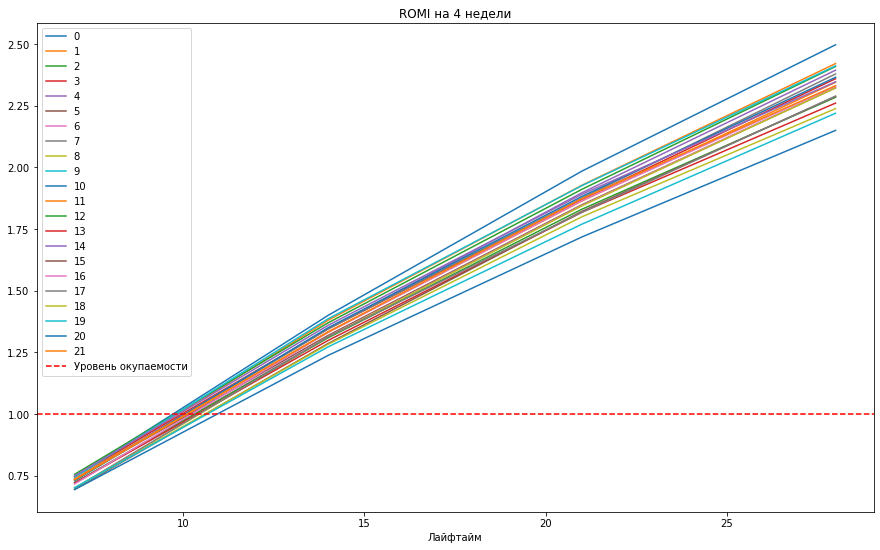

In [102]:
romi[romi.columns[1:]].T.plot(figsize = (15, 9))
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.xlabel('Лайфтайм')
plt.title('ROMI на 4 недели')

Чтобы график на пол года  был точнее я посчитаю romi на 42 дня

In [108]:
romi = pd.DataFrame()
for x in range(8):
    
    cogort = df.loc[(df['first_ts_num'] == x) & (df['day_num'] <= 42 + x)]
    cohort_size = cogort['user_id'].nunique()
    ltv =  (cogort.groupby('day_num')['revenue'].sum() / cohort_size ).cumsum()
    romi = romi.append(    

                { 'cohort_size' :cohort_size, 
                   7 : ltv[7 + x] / cac, 
                14 : ltv[14 + x]/ cac,
                21 : ltv[21 + x]/ cac,
                28 : ltv[28 + x] / cac, 
                35 : ltv[35 + x] / cac, 
                42 : ltv[42 + x] / cac

                }, ignore_index=True
            )
romi

,cohort_size,7,14,21,28,35,42
0,370.0,0.719279,1.350896,1.915081,2.409586,2.897347,3.328914
1,546.0,0.711334,1.337369,1.867442,2.345726,2.776792,3.168254
2,575.0,0.740545,1.343684,1.874504,2.363380,2.801632,3.192154
3,633.0,0.717362,1.294142,1.798660,2.270332,2.706530,3.095429
4,661.0,0.715913,1.311039,1.848288,2.332693,2.789418,3.195814
5,542.0,0.713515,1.279723,1.793761,2.254093,2.679133,3.058140
6,474.0,0.700074,1.277328,1.794926,2.261642,2.682739,3.051199
7,436.0,0.709587,1.304725,1.819748,2.308066,2.762049,3.179790


In [109]:
romi_average =  romi[romi.columns[1:]].mean().reset_index().rename(columns = {'index': 'day', 0:'romi'})

In [110]:
romi_average

,day,romi
0,7,0.715951
1,14,1.312363
2,21,1.839051
3,28,2.318190
4,35,2.761955
5,42,3.158712


In [111]:
model = LinearRegression().fit(np.array(romi_average['day']).reshape(-1, 1), romi_average['romi'])
model.predict(np.array(romi_average['day']).reshape(-1, 1))

array([0.80043812, 1.28734432, 1.77425052, 2.26115671, 2.74806291,
       3.2349691 ])

In [112]:
model.predict(np.array(romi_average['day']).reshape(-1, 1))

array([0.80043812, 1.28734432, 1.77425052, 2.26115671, 2.74806291,
       3.2349691 ])

In [113]:
model.predict(np.arange(7, 182, 7).reshape((-1, 1)))

array([ 0.80043812,  1.28734432,  1.77425052,  2.26115671,  2.74806291,
        3.2349691 ,  3.7218753 ,  4.2087815 ,  4.69568769,  5.18259389,
        5.66950009,  6.15640628,  6.64331248,  7.13021867,  7.61712487,
        8.10403107,  8.59093726,  9.07784346,  9.56474966, 10.05165585,
       10.53856205, 11.02546824, 11.51237444, 11.99928064, 12.48618683])

In [120]:
romi_50 = pd.DataFrame()


cogort = df.loc[(df['first_ts_num'] == 0) & (df['day_num'] <= 50)]
cohort_size = cogort['user_id'].nunique()
ltv =  (cogort.groupby('day_num')['revenue'].sum() / cohort_size ).cumsum()
romi_50 = romi_50.append(    

            { 
                7 : ltv[7 ] / cac, 
            14 : ltv[14 ]/ cac,
            21 : ltv[21 ]/ cac,
            28 : ltv[28 ] / cac, 
            35 : ltv[35 ] / cac, 
            42 : ltv[42 ] / cac,
            50 : ltv[50 ] / cac,

            }, ignore_index=True
        )
romi_50

,7,14,21,28,35,42,50
0,0.719279,1.350896,1.915081,2.409586,2.897347,3.328914,3.746995


In [122]:
romi_50 = romi_50.T.reset_index().rename(columns = {'index': 'day', 0:'romi'})

График получился аналогичный LTV, что при статичной стоимости привлечения клиентов неудивительно 

No handles with labels found to put in legend.


Text(0.5, 1.0, 'ROMI')

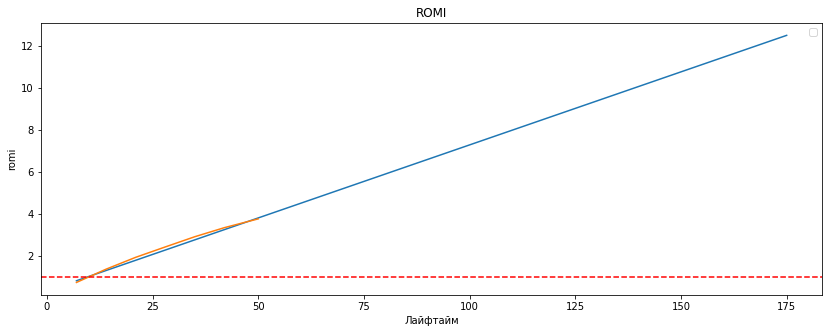

In [124]:
plt.figure(figsize=(14,5))

sns.lineplot(x = np.arange(7, 182, 7), y =  model.predict(np.arange(7, 182, 7).reshape((-1, 1))))
sns.lineplot(x = romi_50['day'], y =  romi_50['romi'])
plt.legend()
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.xlabel('Лайфтайм')
plt.title('ROMI')

**Вывод:** в идеальных условия все получается довольно красиво, я понимаю, что при расчете метрик на реальных данных все намного сложнее, как минимум необходимо было бы учитывать комиссии магазинов. Тут я этого не делал, потому что этого не было в условии.